# Smart Flashcard System - Data Exploration & Model Training

This notebook explores the synthetic study data and trains a logistic regression model to predict flashcard recall probability.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Load and Explore Data

In [2]:
# Load the synthetic study data
df = pd.read_csv('../data/synthetic_data.csv')
print(f"Dataset shape: {df.shape}")
df.head(10)

Dataset shape: (1000, 6)


,card_id,days_since_review,num_reviews,past_accuracy,difficulty,correct
0,23,8,0,0.5,1,1
1,34,3,0,0.5,3,1
2,0,7,0,0.5,4,0
3,14,3,0,0.5,4,1
4,31,2,0,0.5,4,0
5,22,6,0,0.5,4,0
6,28,8,0,0.5,4,0
7,5,3,0,0.5,2,0
8,19,9,0,0.5,4,0
9,38,4,0,0.5,1,0


In [3]:
# Basic statistics
print("Dataset Statistics:")
print("="*50)
print(df.describe())
print(f"\nCorrect recall rate: {df['correct'].mean():.1%}")

Dataset Statistics:
           card_id  days_since_review  num_reviews  past_accuracy  \
count  1000.000000        1000.000000   1000.00000    1000.000000   
mean     24.812000          14.718000     10.04000       0.265071   
std      14.011316          15.069823      6.65708       0.173714   
min       0.000000           0.000000      0.00000       0.000000   
25%      13.000000           4.000000      4.75000       0.143000   
50%      25.000000          10.000000      9.50000       0.286000   
75%      37.000000          20.000000     15.00000       0.389000   
max      49.000000         122.000000     31.00000       1.000000   

        difficulty      correct  
count  1000.000000  1000.000000  
mean      3.199000     0.354000  
std       1.325578     0.478448  
min       1.000000     0.000000  
25%       2.000000     0.000000  
50%       3.000000     0.000000  
75%       4.000000     1.000000  
max       5.000000     1.000000  

Correct recall rate: 35.4%


## 2. Visualize Feature Distributions

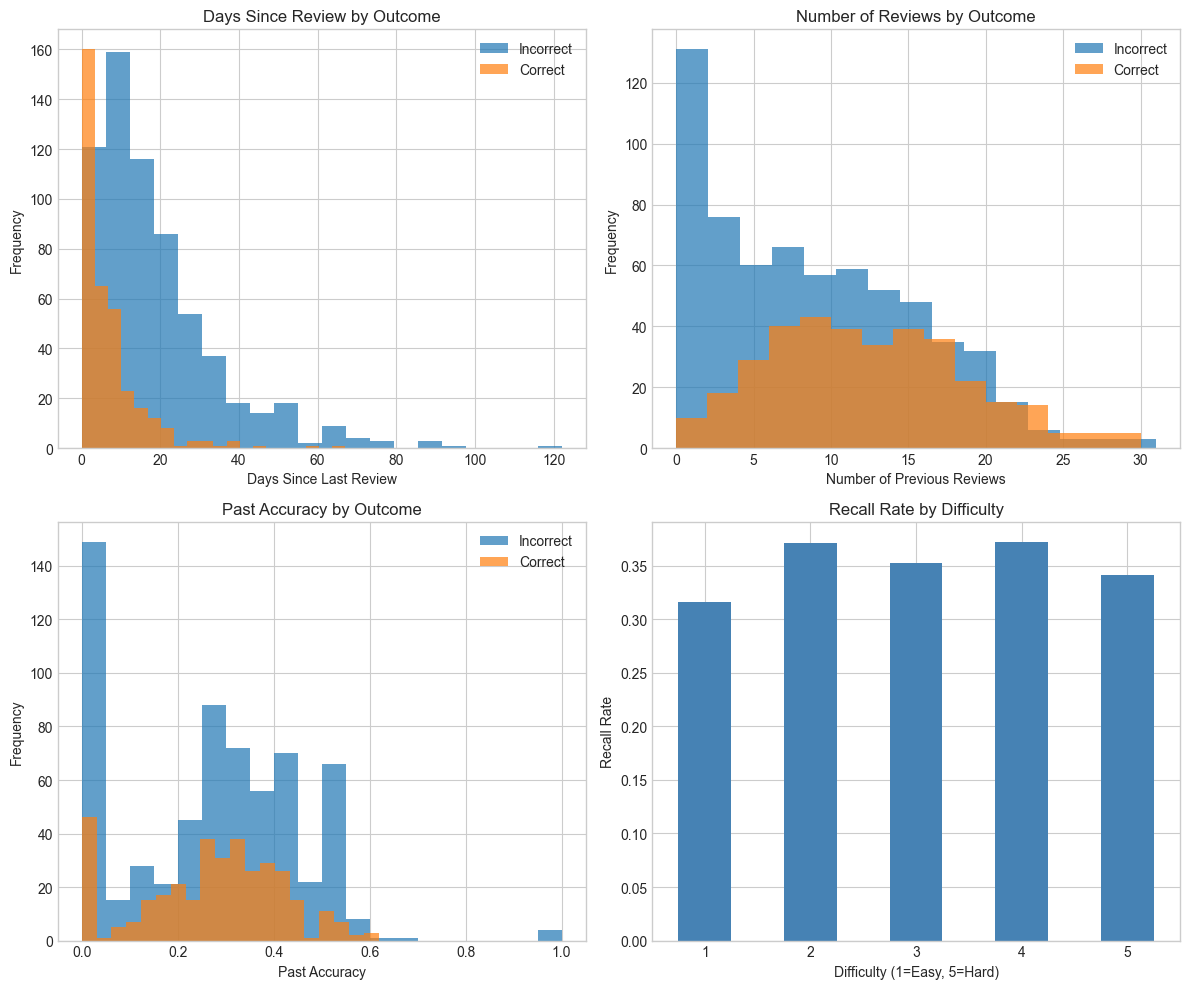

In [4]:
# Create subplots for feature distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Days since review distribution
ax1 = axes[0, 0]
df.groupby('correct')['days_since_review'].hist(ax=ax1, alpha=0.7, bins=20, label=['Incorrect', 'Correct'])
ax1.set_xlabel('Days Since Last Review')
ax1.set_ylabel('Frequency')
ax1.set_title('Days Since Review by Outcome')
ax1.legend(['Incorrect', 'Correct'])

# Number of reviews distribution
ax2 = axes[0, 1]
df.groupby('correct')['num_reviews'].hist(ax=ax2, alpha=0.7, bins=15)
ax2.set_xlabel('Number of Previous Reviews')
ax2.set_ylabel('Frequency')
ax2.set_title('Number of Reviews by Outcome')
ax2.legend(['Incorrect', 'Correct'])

# Past accuracy distribution
ax3 = axes[1, 0]
df.groupby('correct')['past_accuracy'].hist(ax=ax3, alpha=0.7, bins=20)
ax3.set_xlabel('Past Accuracy')
ax3.set_ylabel('Frequency')
ax3.set_title('Past Accuracy by Outcome')
ax3.legend(['Incorrect', 'Correct'])

# Difficulty distribution
ax4 = axes[1, 1]
correct_by_diff = df.groupby('difficulty')['correct'].mean()
correct_by_diff.plot(kind='bar', ax=ax4, color='steelblue')
ax4.set_xlabel('Difficulty (1=Easy, 5=Hard)')
ax4.set_ylabel('Recall Rate')
ax4.set_title('Recall Rate by Difficulty')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('../data/feature_distributions.png', dpi=150)
plt.show()

## 3. Analyze the Forgetting Curve

Forgetting Curve Analysis:
          Recall Rate  Sample Count
days_bin                           
0-1          0.772727            44
2-3          0.701754           114
4-7          0.511628           172
8-14         0.260000           250
15-30        0.127572           243
30+          0.083333           120


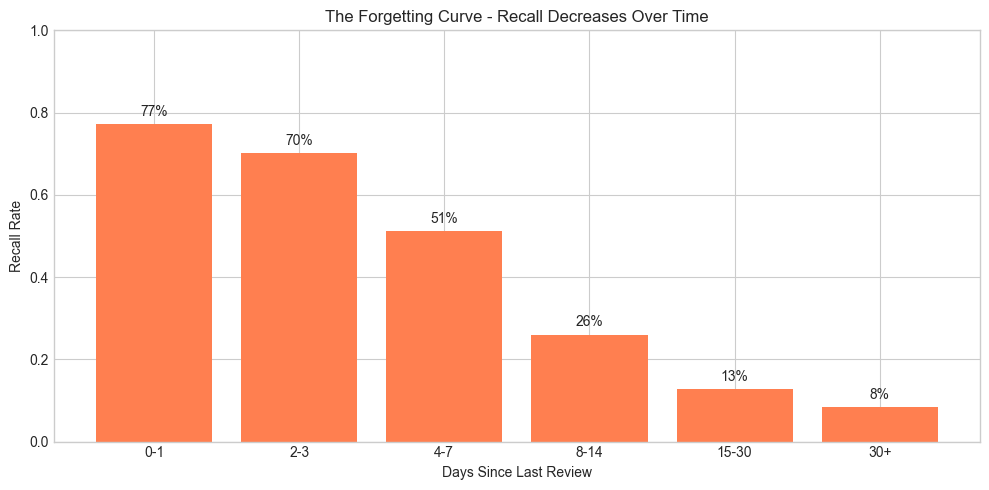

In [5]:
# Bin days_since_review and calculate recall rate
df['days_bin'] = pd.cut(df['days_since_review'], bins=[0, 1, 3, 7, 14, 30, 200], 
                        labels=['0-1', '2-3', '4-7', '8-14', '15-30', '30+'])

forgetting_curve = df.groupby('days_bin', observed=True)['correct'].agg(['mean', 'count'])
forgetting_curve.columns = ['Recall Rate', 'Sample Count']
print("Forgetting Curve Analysis:")
print(forgetting_curve)

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(len(forgetting_curve)), forgetting_curve['Recall Rate'], color='coral')
plt.xticks(range(len(forgetting_curve)), forgetting_curve.index)
plt.xlabel('Days Since Last Review')
plt.ylabel('Recall Rate')
plt.title('The Forgetting Curve - Recall Decreases Over Time')
plt.ylim(0, 1)
for i, v in enumerate(forgetting_curve['Recall Rate']):
    plt.text(i, v + 0.02, f'{v:.0%}', ha='center')
plt.tight_layout()
plt.savefig('../data/forgetting_curve.png', dpi=150)
plt.show()

## 4. Train Logistic Regression Model

In [6]:
# Prepare features and target
feature_cols = ['days_since_review', 'num_reviews', 'past_accuracy', 'difficulty']
X = df[feature_cols]
y = df['correct']

print(f"Features shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

Features shape: (1000, 4)
Target distribution: {0: 646, 1: 354}


In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 800 samples
Test set: 200 samples


In [8]:
# Train logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Model trained successfully!")

Model trained successfully!


## 5. Evaluate Model Performance

In [9]:
# Accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.1%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Incorrect', 'Correct']))

Model Accuracy: 76.5%

Classification Report:
              precision    recall  f1-score   support

   Incorrect       0.79      0.87      0.83       129
     Correct       0.71      0.58      0.64        71

    accuracy                           0.77       200
   macro avg       0.75      0.72      0.73       200
weighted avg       0.76      0.77      0.76       200



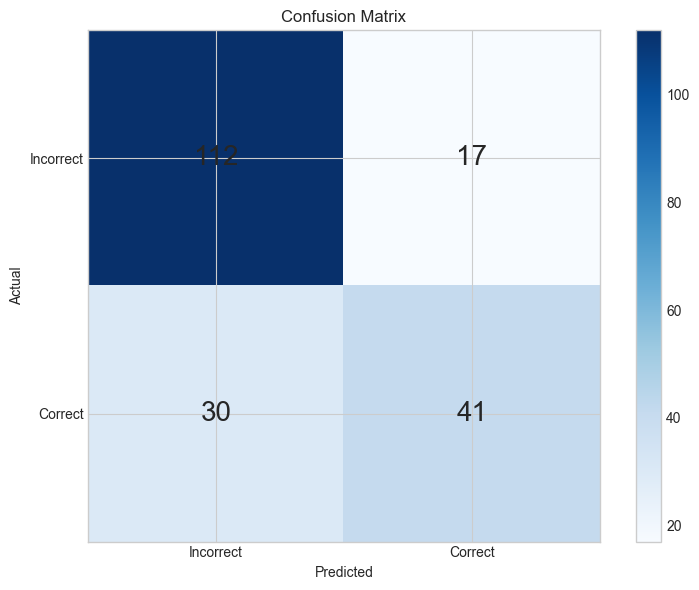

In [10]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks([0, 1], ['Incorrect', 'Correct'])
plt.yticks([0, 1], ['Incorrect', 'Correct'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=20)
plt.tight_layout()
plt.savefig('../data/confusion_matrix.png', dpi=150)
plt.show()

## 6. Analyze Feature Importance

In [11]:
# Feature coefficients (importance)
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient')

print("Feature Coefficients (Logistic Regression):")
print(coef_df)
print("\nInterpretation:")
print("- Positive coefficient = increases recall probability")
print("- Negative coefficient = decreases recall probability")

Feature Coefficients (Logistic Regression):
             Feature  Coefficient
0  days_since_review    -0.117041
2      past_accuracy    -0.112553
3         difficulty     0.036489
1        num_reviews     0.077291

Interpretation:
- Positive coefficient = increases recall probability
- Negative coefficient = decreases recall probability


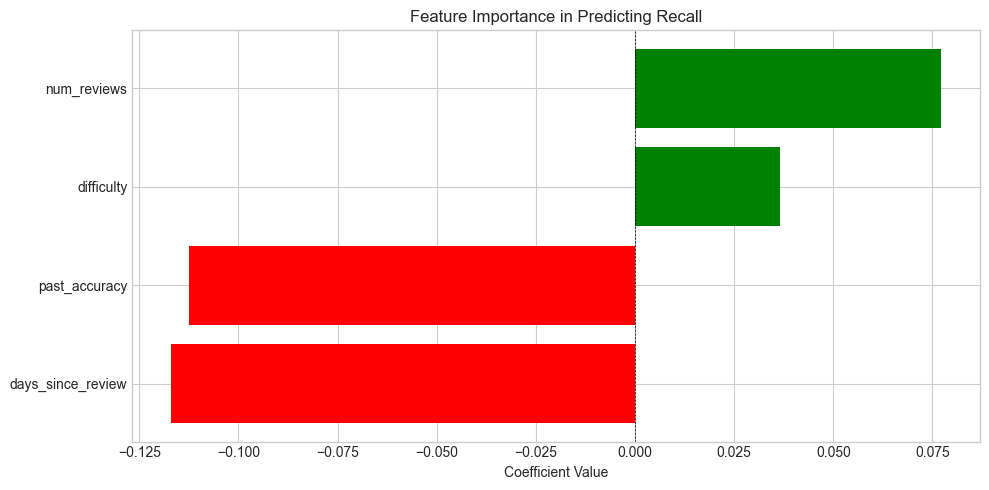

In [12]:
# Visualize coefficients
plt.figure(figsize=(10, 5))
colors = ['red' if c < 0 else 'green' for c in coef_df['Coefficient']]
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Predicting Recall')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('../data/feature_importance.png', dpi=150)
plt.show()

## 7. Save the Trained Model

In [13]:
import pickle

# Save model
with open('../models/trained_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved to ../models/trained_model.pkl")

Model saved to ../models/trained_model.pkl


## 8. Test Predictions

In [14]:
# Test predictions on sample scenarios
test_cases = [
    {'days_since_review': 0, 'num_reviews': 5, 'past_accuracy': 0.8, 'difficulty': 2},  # Recently reviewed, good history
    {'days_since_review': 30, 'num_reviews': 1, 'past_accuracy': 0.3, 'difficulty': 4}, # Old, poor history
    {'days_since_review': 7, 'num_reviews': 3, 'past_accuracy': 0.5, 'difficulty': 3},  # Medium
]

print("Sample Predictions:")
print("="*60)
for i, case in enumerate(test_cases, 1):
    X_sample = pd.DataFrame([case])
    prob = model.predict_proba(X_sample)[0][1]
    print(f"\nScenario {i}: {case}")
    print(f"  → Predicted recall probability: {prob:.1%}")

Sample Predictions:

Scenario 1: {'days_since_review': 0, 'num_reviews': 5, 'past_accuracy': 0.8, 'difficulty': 2}
  → Predicted recall probability: 54.0%

Scenario 2: {'days_since_review': 30, 'num_reviews': 1, 'past_accuracy': 0.3, 'difficulty': 4}
  → Predicted recall probability: 2.8%

Scenario 3: {'days_since_review': 7, 'num_reviews': 3, 'past_accuracy': 0.5, 'difficulty': 3}
  → Predicted recall probability: 32.2%


## Summary

**Key Findings:**
1. The forgetting curve is clearly visible - recall drops as time since review increases
2. More reviews and higher past accuracy increase recall probability
3. Higher difficulty cards are harder to recall
4. Logistic regression achieves good accuracy on this prediction task

**Next Steps:**
- Use the trained model in the flashcard app to schedule reviews
- Cards with low predicted recall should be prioritized
- Collect real feedback to improve the model over time